# Bayesian Learning Assignment 2

MSc DSAI Quentin Le Roux

<hr>
<hr>
<hr>

## Library Imports

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.optimize import minimize
from scipy.stats import norm, uniform, binom
from scipy.stats import multivariate_normal
from sklearn import datasets 

<hr>

## Function declarations

**Note**: 
- *Functions are listed per exercise in alphabetical orders*
- *Functions are provided with Type Hinting*

### Exercise 1 functions

In [2]:
def beta_binomial_distribution(
    n: int, y: int, alpha: int, beta: int
) -> np.array:
    """
    Returns the beta-binomial distribution over the space of 
    parameter theta, given the parameters alpha, beta, y, and n.
    """
    # Declares a linear space for the parameter theta
    theta_space  = np.linspace(0,1)
    # Computes and return the distribution
    distribution = theta_space**(y+alpha-1) * \
                   (1-theta_space)**(n+beta-y-1)
    return theta_space, distribution

def beta_binomial_lapproximation(
    n: int, y: int, alpha: int, beta: int
) -> np.array:
    """
    Returns the Laplace approximation of the beta binomial
    distribution (a Gaussian distribution) with parameters
    derived from the original distribution's parameters alpha,
    beta, y, and n.
    """
    theta_max = (y+alpha-1)/(n+alpha+beta-2)
    hessian   = -(y+alpha-1)/(theta_max**2) - \
                (n+beta-y-1)/((1-theta_max)**2)
    variance  = -1/hessian
    return norm(theta_max, np.sqrt(variance))

### Exercise 4 functions

In [3]:
def evaluate_log_post(
    params: list, 
    other_params: list, 
    data: pd.Series, 
    likelihood: str, 
    priors: list
) -> float:
    """
    Optimization function to be used for performing a Laplace
    approximation.
    """
    # Retrieves the distribution function (scipy implementation)
    models = {
        'gaussian':norm, 
        'uniform':uniform,
        'binomial':binom
    }
    #Computes the log-priors
    log_prior = np.sum([models[model[0]].logpdf(params[i], *model[1]) 
                        for i, model in enumerate(priors)])         
    # Guarantees positive variance in the Gaussian case
    if likelihood == 'gaussian': params[-1] = np.abs(params[-1])
    # Checks for the other set of parameters
    if len(other_params) > 0: params = (params, other_params)
    # Computes the log-likelihood
    log_likelihood = np.sum([models[likelihood].logpdf(point, *params) 
                             for point in data])
    return - (log_likelihood + log_prior)

def laplace_solution(
    params:list,
    other_params: list,
    data: pd.Series,
    likelihood: str,
    priors:list
) -> list:
    """
    Computes a Laplace approximation of a distribution given sets of
    prior and likelihood parameters.
    """    
    # Performs an optimization over a set of parameters given an
    # evaluation function.
    minimum =  minimize(
        evaluate_log_post, params,  
        args = (other_params, data, likelihood, priors), 
        method = 'BFGS'
    )
    print(minimum)
    return [minimum.x, minimum.hess_inv]

def plot_relationship(
    x: pd.Series, y: pd.Series,
    xlabel: str, ylabel:str,
    title: str
) -> None:
    """
    Plots the 2D plot of the relationship between two variables.
    """
    plt.figure()
    plt.scatter(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show

### Exercise 5 functions

### Exercise 6 functions

<hr>
<hr>
<hr>

## Exercise 1

### Instructions

The Beta-Binomial model seen during lesson 2 is:

$$p(y|\theta)p(\theta) \propto \theta^{y+\alpha-1}(1-\theta)^{n+\beta-y-1} \propto Beta(\theta|\alpha+y,n+\beta-y).$$

Find a Laplace approximation for this model, as seen for the Binomal model, and plot the resulting Gaussian approximation against the Beta-Binomial function.

<hr>

#### 1. Finding the Laplace approximation of the Beta-Binomial model

We recall that the Laplace method approximate the shape of a given function through the application of a Gaussian distribution. This approximation relies on the Taylor expansion of the (log-)function of interest *f*. *f* is the function to approximate. We declare the function *g* such that:

$$f(x) = \exp(\log(f(\theta)) = \exp(g(\theta))$$

Stopping at the second order, and assuming that *g* and *f* share a maximum in $\theta_0$, we can approximate *g* and thus *f* for any point $theta$ sufficiently close to $\theta_0$ such that:

\begin{align}
g(\theta) &= g(\theta_0) + g'(\theta_0)(\theta-\theta_0) + \frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2 + o((\theta - \theta_0)^3)\\
g'(\theta_0) = 0 \\
\end{align}

We find the following approximation:

\begin{align}
g(\theta) &\approx g(\theta_0) + \frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2\\
f(\theta_0) &\approx f(\theta_0) + \exp(\frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2) \\
&\approx \exp\big(\frac{1}{2}g''(\theta_0)(\theta-\theta_0)^2\big)\quad\text{Given $f(\theta_0)$ a constant}\\
&\approx \exp\big(-\frac{1}{2}\frac{(\theta-\theta_0)^2}{-\frac{1}{g''(\theta_0)}}\big)\quad\text{We recognize a Gaussian PDF}\\
\end{align}

As such, *f* can be approximated (up to a normalization constant) by a Gaussian distribution $\mathcal{N}(\theta_0, -\frac{1}{g''(\theta_0)})$

<u>Computing the maximum of the log-distribution:</u>

\begin{align}
g(\theta) & = \log(f(\theta)) = (y+\alpha-1)*\log(\theta) + (n+\beta-y-1)*\log(1-\theta)\\
\frac{\delta g}{\delta \theta} &= \frac{y+\alpha-1}{\theta} - \frac{n+\beta-y-1}{1-\theta}
\end{align}

As such:

\begin{align}
g'(\theta_0) &= 0\\
&\Rightarrow \frac{y+\alpha-1}{\theta_0} - \frac{n+\beta-y-1}{1-\theta_0} = 0\\
&\Rightarrow \frac{(1-\theta_0)*(y+\alpha-1) - \theta_0*(n+\beta-y-1)}{\theta_0(1-\theta_0)} = 0\\
&\Rightarrow (1-\theta_0)*(y+\alpha-1) - \theta_0*(n+\beta-y-1) = 0 \\
&\Rightarrow (2-n-\alpha-\beta)*\theta_0 +y+\alpha-1 = 0
\end{align}

We find:

$$\theta_0 = \frac{y+\alpha-1}{n + \alpha + \beta - 2}$$

<u>Computing the second derivative of the log-distribution with respect to $\theta$:</u>

\begin{align}
\frac{\delta^2 g}{\delta \theta^2} &= -\frac{y+\alpha-1}{\theta^2} - \frac{n+\beta-y-1}{(1-\theta)^2}
\end{align}

We find:

$$g''(\theta_0) = -\frac{y+\alpha-1}{(\frac{y+\alpha-1}{n + \alpha + \beta - 2})^2} - \frac{n+\beta-y-1}{(1-(\frac{y+\alpha-1}{n + \alpha + \beta - 2}))^2}$$

<u>Concluding on finding the Laplace approximation of the Beta-Binomial model:</u>

The approximation will be the Gaussian:

$$\mathcal{N}\big(\frac{y+\alpha-1}{n + \alpha + \beta - 2}, -(-\frac{y+\alpha-1}{(\frac{y+\alpha-1}{n + \alpha + \beta - 2})^2} - \frac{n+\beta-y-1}{(1-(\frac{y+\alpha-1}{n + \alpha + \beta - 2}))^2})^{-1}\big)$$

with mean $\theta_0 = \frac{y+\alpha-1}{n + \alpha + \beta - 2}$ and variance $\sigma^2=(\frac{y+\alpha-1}{(\frac{y+\alpha-1}{n + \alpha + \beta - 2})^2} + \frac{n+\beta-y-1}{(1-(\frac{y+\alpha-1}{n + \alpha + \beta - 2}))^2})^{-1}$

#### 2. Plotting the approximation

For plotting the resulting approximation, we will reuse the values for $\alpha$, $\beta$, $n$, and $y$ from class 5.

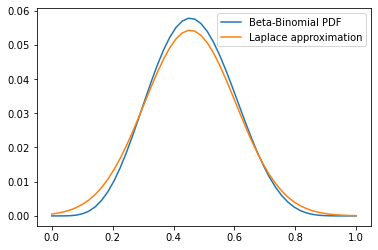

In [4]:
# Variable declarations

y = 4; n = 8; alpha = 2; beta = 3

# Computing the beta-binomial PDF
theta_space, beta_binomial = beta_binomial_distribution(n, y, alpha, beta)

# computing the beta-binomia approximation
lapproximation = beta_binomial_lapproximation(n, y, alpha, beta)

# Plotting the results

plt.figure()
plt.plot(
    theta_space, 
    beta_binomial/np.sum(beta_binomial), 
    label="Beta-Binomial PDF")
plt.plot(
    theta_space,
    lapproximation.pdf(theta_space)/np.sum(lapproximation.pdf(theta_space)),
    label="Laplace approximation")
plt.legend()
plt.show()

<hr>
<hr>
<hr>

## Exercise 2

### Instructions

Write down a model to evaluate the claim: *Animal diversity is related to latitude, but only after controlling for plant diversity*. You just need to write down the model definition.

<hr>

#### 1. Problem statement

From [wikipedia](https://en.wikipedia.org/wiki/Latitude), "*latitude is a geographic coordinate that specifies the north–south position of a point on the Earth's surface. Latitude is an angle (defined below) which ranges from 0° at the Equator to 90° (North or South) at the poles*." 

Common sense can lead us to assume that animal diversity is closely correlated to location (here, latitude). Furthermore, given prior belief, we may suppose that the most inhospitable areas in the world are located towards the poles, while the most hospitable would be closer to the equator (e.g. Amazonian Forest, Subsaharan Africa, etc.). Furthermore, since a biome is constituted by both fauna and flora, we can suppose that animal and plant diversity are correlated.

As a caveat, this modeling is not without blind spots as areas such that the Sahara desert might influence the average diversity of a locale/latitude, as we are not interested in longitude as a parameter.

Finally, given these assumptions, we may hypothesize that:

- Any metric related to latitude would display some symmetric behavior with regards to the distance from the equator.
- The closer to the poles, i.e. the farther from the equator, the lower biome diversity is
    - Animal diversity and plant diversity are related
    - Diversity decreases with latitude.

**Note:** Assuming any metric of animal diversity cannot be negative (at worse it would be zero), we could imagine a diversity metric as following a Poisson distribution at a given latitude.

<u>Possible example of a diversity metric per latitude given our assumptions:</u>

Represented on a graph with the x-axis the distance from the equator, and on the y-axis a metric evaluating animal diversity, we would expect a possibly linear, decreasing dataset of a form.

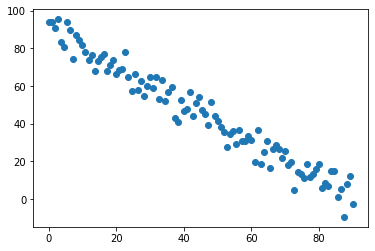

In [5]:
x = np.linspace(0, 90, num=100)
y = sorted(np.linspace(0, 90, num=100), reverse=True) + \
    np.random.normal(0, 5, 100)
plt.scatter(x, y); plt.show()

#### 2. Model definition

As such, since we are interested in a possible relationship between latitude and animal diversity, but we also want to account/control for plant diversity, we could defined a preliminary model as a linear regression with `animal diversity` as the dependent variable and `latitude` and `plant diversity` as its covariates. 

We are interested in the regression function $r$ such that:

$$r \rightarrow \mathbb{E}[animal\,diversity\,\,|\,\,latitude,\,\, plant\,diversity]$$

This results in the following possibly linear relationship:

\begin{align}
\text{animal diversity} &= a+b*\text{latitude} + c*\text{plant diversity}\\\\
\text{with,}\\
a&,\text{ the intercept}\\
b, c&,\text{ resp. covariates of latitude and plant diversity}
\end{align}

<hr>
<hr>
<hr>

## Exercise 3

### Instructions

Invent your own example of spurious correlation. An outcome variable should be correlated with both predictor variables. But when both predictors are entered in the same model, the correlation between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

<hr>

#### 1. Example of spurious correlation

From [Investopedia](https://www.investopedia.com/terms/s/spurious_correlation.asp), "*a spurious correlation (or spuriousness) refers to a connection between two variables that appears to be causal but is not. With spurious correlation, any observed dependencies between variables are merely due to chance or are both related to some unseen confounder.*"

An example could be the following:

> The sale of foie-gras is spuriously correlated to the sale of umbrellas in the Alpes-Maritimes, France.

If at face value it is obvious that the two variables are not causally linked, they are correlated through the underlying variable of seasonality -- the [rainiest months in the Alpes-Maritimes are during the months of October, November and December](https://en.wikipedia.org/wiki/Nice#Climate). Furthermore, foie-gras sales are [closely tied to the Christmas and New Year holidays](https://www.businesscoot.com/fr/etude/le-marche-du-foie-gras-france).

As such, we have a situation where the sale of foie-gras, being our dependent variable, should be correlated to both predictor variables: season/month of the year, and sales of umbrellas. Given a model where both covariates are included, we would expect the predictive aspect of the sales of umbrellas to decrease or disappear.

<hr>
<hr>
<hr>

## Exercise 4

### Instructions

The attached data is about observations of urban foxes in human habitat. The data has 5 columns:

- *group*: Number of social group the fox belongs to
- *avgfood*: The avg amount of food available in the territory
- *groupsize*: The number of foxes in the social group
- *area*: Size of the territory
- *weight*: Body weight of the fox

Fit a regression for *weight* as a linear function of *area*, and a regression for *weight* as a linear function of *groupsize*. What can you say about these relationships? Run a multivariate model and plot counterfactual plots for both variables. What can you conclude about this analysis?

<hr>

#### 1. Data import and exploration

In [6]:
data = pd.read_csv("data.csv")
data.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


[Text(0.5, 1.0, "Distribution of urban foxes' weight")]

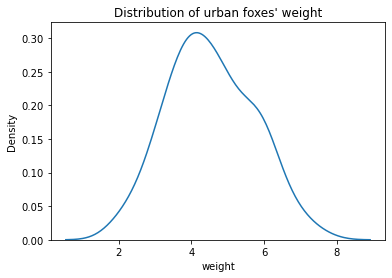

In [7]:
sns.kdeplot(data["weight"]).set(title="Distribution of urban foxes' weight")

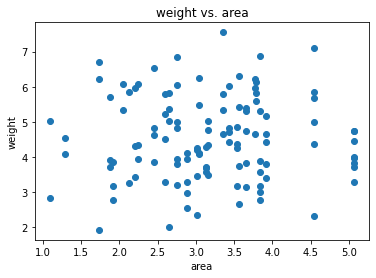

In [8]:
x, y, title= ("area", "weight", "weight vs. area")
plot_relationship(data[x], data[y], x, y, title)

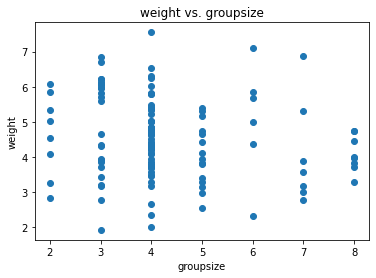

In [9]:
x, y, title= ("groupsize", "weight", "weight vs. groupsize")
plot_relationship(data[x], data[y], x, y, title)

#### 3. Estimating a model of `weight` sampling from prior mean and variance

<u>Selecting priors:</u>

We start by fitting a model for the variable `weight` only. Given the observed sample distribution, we can weakly assume that `weight` is Gaussian-distributed. `weight` is the result of infinitesimal accumulations of mass/growth during the life span (such as with the variable `height` seen in class).

Therefore, for each fox $i$, we may assume that their `weight` is distributed as: $\quad\text{weight}_i\sim N(\mu,\sigma^2)$.

As we can consider foxes as being fungible individuals, we can also state independence between each observation such that:

$$p(\text{weight}) = p(\text{weight}_1, \text{weight}_2, \ldots, \text{weight}_N) = p(\text{weight}_1).p(\text{weight}_2)\cdots p(\text{weight}_N)$$

This corresponds to a product of Gaussian likelihoods. Once set on using a Gaussian likelihood, we look into specifing a prior. We can use a Gaussian model encoding our belief by assuming:

\begin{align}
\mu_{prior} &\sim\,\,\mathcal{N}(4.5,3)\\
\sigma_{prior} &\sim\,\,\mathcal{U}(0,2)
\end{align}

**Interpretation**: The average weight of an urban fox is 4.5 kilograms with a $2\sigma$-variability of $[0.9kg, 8.1kg]$, which seem reasonable as we are including the whole fox population, from pups to the largest individuals. For the variance, we don't have a clear opinion on the matter and we can simply say that it is uniformly distributed on the interval $[0kg, 2kg]$.

<u>Integrating data in the model and obtaining its posterior:</u>

We specify our likelihood:

\begin{align}
p(y|\mu,\sigma^2) &= N(y|\mu,\sigma^2)\\\\
\text{with}&\,\\
y&,\,\,\text{the weight data}
\end{align}

<u>Using Laplace approximation:</u>

Because a grid method is computationally inefficient, and because we need to perform inference on $\sigma$ as well (which makes us reject using the closed form of the Gaussian), we use the Laplace approximation in order to yield a model of `weight`. As such, we rely on **Laplace approximation** to compute a Gaussian approximation of the model.

\begin{align}
P(\mu, \sigma|h_i, a, b, \mu_0, \sigma_0) &\approx P(h_i|\mu,\sigma).p(\mu, \sigma|a,b,\mu_0, \sigma_0)\\
&\approx \mathcal{N}([\mu^*, \sigma^*], \Sigma)\\
\end{align}

We rely on the optimizer offered by the SciPy library to perform our approximation:

In [21]:
# Initializing the likelihood with the sample parameters
likelihood = 'gaussian'; mu=4.53; sigma=1.18 #4.53, 1.18
parameters = [mu, sigma]

# Defining the prior mean
prior_mu_mean = 4.5; prior_mu_sigma = 3
prior_mu = ['gaussian', [prior_mu_mean, prior_mu_sigma]]

# Definint the prior sigma
sigma_inf = 0.; sigma_sup = 2.
prior_sigma = ['uniform', [sigma_inf, sigma_sup]]

solution = laplace_solution(parameters, [], data["weight"], likelihood, [prior_mu, prior_sigma])

      fun: 186.399890424752
 hess_inv: array([[1.19675967e-02, 4.41943897e-06],
       [4.41943897e-06, 5.99152106e-03]])
      jac: array([-5.7220459e-06,  0.0000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([4.5296157 , 1.17890797])


The variable `solution` contains both the distribution of the mean and covariance of the posterior of `weight`, i.e., the parameters $\mu$ and $\sigma$. As such, we explore this new model of `weight`:

In [32]:
print(f"The mean of the `weight` parameters are: {posterior_samples.mean(axis=0)}.")
print(f"The standard deviation of the `weight` parameters are: {posterior_samples.std(axis=0)}.")
print(f"\nThe 85% quantile bounds for the `weight` parameters are:\n",
      np.quantile(posterior_samples, q=[0.075, 0.925], axis=0))

The mean of the `weight` parameters are: [4.513201   1.18498722].
The standard deviation of the `weight` parameters are: [0.11253443 0.0738169 ].

The 85% quantile bounds for the `weight parameters` are:
 [[4.35099465 1.07539557]
 [4.67189612 1.29665875]]


#### 3. Performing a regression with `weight` as a linear function of `area`

we are interested in the relationship: 

$$\text{weight} = a + b * \text{area}$$

As such, we would like to obtain the posterior distribution for the regression intercept $a$ and slope $b$. Given our observation of the distribution of `weight` above, we have a weak belief that the prior distribution of `weight` is Gaussian such that: 

$$\text{weight}_i\sim \mathcal{N}(\mu_i,\sigma^2)$$

Furthermore, to proceed with a Bayesian treatment, and even though it does not really appear on the graph above, we will assume that this prior Gaussian model of `weight` is dependent on the variable `area`. To completely define our Bayesian model, we specify priors for all the parameters we want to analyze:

$$ p(a) = N(, )$$

$$ p(b) = N(, )$$

$$ p(\sigma) = U(, )$$

#### 4. Performing a regression with `weight` as a linear function of `groupsize`

#### 5. Comment on the two regressions

#### 6. Performing a multivariate model

#### 6. Conclusion

<hr>
<hr>
<hr>

## Exercise 5

Consider the diabetes dataset

In [ ]:
dataset = datasets.load_diabetes(return_X_y=False)
print(dataset.DESCR)

In [ ]:
# Define the feature matrix
data = dataset.data
# Define the target
target = dataset.target

Investigate the relationship between age (data[:,0]) and Average blood pressure (data[:,3]). 
By using the WAIC score seen during lesson, can you verify which hypothesis is better supported by the data?

- there is no relationship (constant)
- the relationship is linear
- the relationship is quadratic
- the relationship is cubic
- the relationship is polynomial of order 4

<hr>
<hr>
<hr>

## Exercise 6

Which model would you support between the following:

- target depends on _Age_
- target depends on _Age_ and _Sex_
- target depends on _Age_ and _Body mass index_ 
- target depends on _Age_ and _Body mass index_ and _Average blood pressure_
- target depends on _Age_ and _Sex_ and _Body mass index_ 
- target depends on _Age_ and _Sex_ and _Body mass index_ and _Average blood pressure_
- target depends on  _Body mass index_ and _Average blood pressure_

